Modelagem de Falha de Equipamento
======

`Conteúdo disponível no livro Bayesian Method for hackers`

___


Nesse notebook vamos desenvolver uma modelagem de falha de um equipamento. OS dados utilizados são de um acidente que ocoreu com propulsores do foguete Shuttle Challenger que explodiram logo após a decolagem. O acidente ocorreu devido a falha em um anel de conexão no propulsor do foguete. Tal falha aconteceu devido a um projeto defeituoso que tornou o anel de conexão inaceitavelmente sensível a vários fatores, incluindo a temperatura externa [1](https://www.jstor.org/stable/2290069#metadata_info_tab_contents). 

A ideia aqui é modelar a probabilidade de falha no anel de conexão do propulsor do foguete de acordo com a temperatura externa.



Temp (F), Falha no Anel de conexão
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


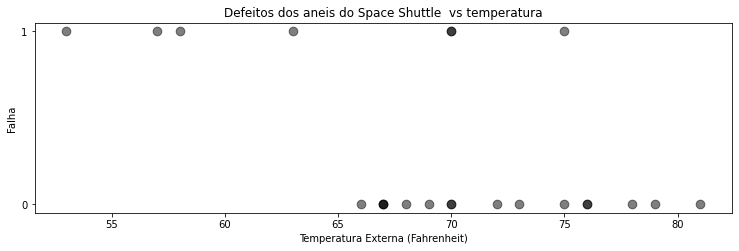

In [73]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), Falha no Anel de conexão")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Falha")
plt.xlabel("Temperatura Externa (Fahrenheit)")
plt.title("Defeitos dos aneis do Space Shuttle  vs temperatura");
#(challenger_data[:, 0] -32) / 1.8 

Olhando para o gráfico acima, podemos ver que a probabilidade de defeito aumenta quando a temperatura externa diminui. Além disso, não podemos apontar no plot um cutoff point  entre temperatura e ocorrência de falha que seja tão nítida. O que vamos modelar é : qual a probabilidade de falha no anel de conexão na temperatura $t$.

Primeiramente, precisamos de uma função para temperatura $p(t)$ que nos dará resultados entre 0 e 1 para modelar a probabilidade e que mude de 1 para 0 com o aumentar da temperatura. Existem muitas funções que poderíamos utilizar, mas vamos utilizar a mais popular: *logistic function.*


$$p(t) = \frac{1}{ 1 + e^{ \;\beta t } } $$

No nosso modelo, $\beta$ é a variável que queremos avaliar. Abaixo temos a função de temperatura para  $\beta = 1, 3, -5$.


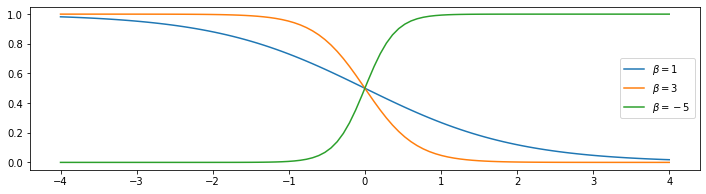

In [57]:
figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend();


olhando para os plots acima, podemos notar que na *logistic function* as probabilidades começam a ter alterações somente próximo de zero e isso é diferente do que observamos nos nossos dados. Para as nossas observações, essas mudanças começam por volta de 65 a 70 graus. Dessa forma, precisamos adicionar um bias na nossa função:

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Vemos abaixo alguns plots com diferentes valores de $\alpha$.

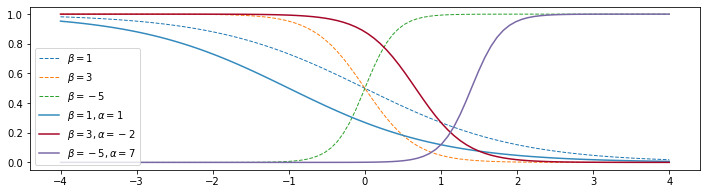

In [58]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

Adicionando $\alpha$, podemos fazer com que a curva se desloque tanto para a esquerda como para a direita.

Os parâmetros $\beta, \alpha$ são os quais estamos interessados em estimar. Além disso, iremos modela-los como uma variável aleatória normal devido aos seguintes fatos:
* Não faz sentido para nossa modelagem termos esses parâmetros negativos
* Os parâmetros não precisam ser grandes demais
* Não temos limites pré estabelecidos para os mesmos

In [61]:
import pymc3 as pm
import theano.tensor as tt

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # Target -> defeito ou não

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))

No código acima nós criamos os duas variáveis aleatórias com distribuição Normal que são nossos parâmetros e uma função (variável) determinística p, que representa nossa função de temperatura para diferentes valores beta, temperatura e alpha. 

Para associar essas probabilidades aos nossos dados observados, podemos lembrar que a variável aleatória de *Bernoilly* $\text{Ber}(p)$ possui valor 1 com probabilidade $p$ e 0 caso contrário. Podemos então modelar da seguinte forma:

$$ \text{Defect Incident, $D_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

onde :
* $p(t)$ é nossa *logistic function* 
* $t_i$ é a temperatura das nossas observações

No código abaixo nós atribuimos 0 a`beta` e `alpha`. Fazemos isso porque se `beta` e `alpha` são muito grandes, eles fazem com que `p` seja 1 ou 0 e a `pm.Bernoulli` não pode ser atribuído exatamentes 0 ou 1, embora matematicamente isso seja possível. Diante disso, quando estamos definindo o coeficiente `0` para a variável `p` estamos apensa fazendo com que não tenhamos problemas no PyMC3. Isso não sifnifica que estamos incluindo qualquer informação adicional a nossa a priori e não possui nenhum efeito no nosso resultado final.

In [71]:
# connectando as probabilidades em `p` com nossas observações 
# através de uma variável aleatória de Bernoulli.
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    # Essa parte do código será melhor explicada em outros notebooks
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

c:\users\jonathanmoura\appdata\local\programs\python\python39\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\users\jonathanmoura\appdata\local\programs\python\python39\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


<ipython-input-71-c019d1999bcb>:9: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(120000, step=step, start=start)
c:\users\jonathanmoura\appdata\local\programs\python\python39\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


Sampling 4 chains for 1_000 tune and 120_000 draw iterations (4_000 + 480_000 draws total) took 2655 seconds.
The number of effective samples is smaller than 10% for some parameters.


O código acima treina nosso modelo nos dados observados, agora podemos pegar amostragens da distribuição a posteriori. Vamos olhar as distribuições a posteriori de α e β:

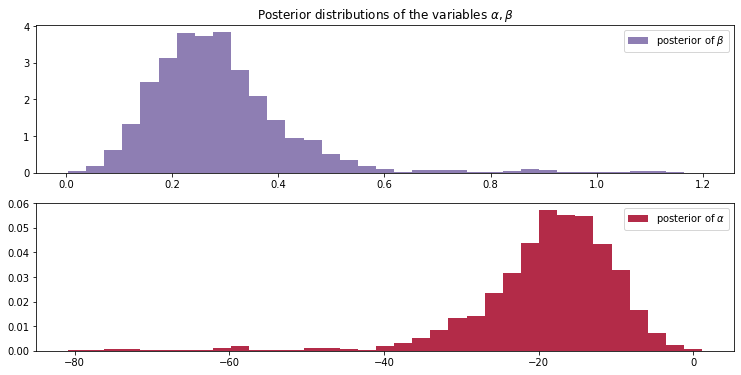

In [76]:
alpha_samples = burned_trace["alpha"][:, None]  # transformando em 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogramas das amostras:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", density=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", density=True)
plt.legend();

Todas as amostras de $\beta$ são maiores que 0. Caso a  posteriori fosse centrada em torno de 0, poderíamos suspeitar que $\beta = 0$. Isso implicaria que a temperatura não possui efeito na probabilidade de defeitos.

Podemos também observar que os valores a posteriori de $\alpha$ são negativos. Isso implica que está correto afirmar que $\alpha$  é provavelmente menor que 0.

Com relação ao formato da distribuição, podemos ver que temos distribuições bem dispersas. Isso significa que temos grandes incertezas com relação ao verdadeiro valor dos parâmetros. Esse comportamento da modelagem é esperado, visto que temos uma quantidade pequena de amostras e desbalanceamento de classes.

Vamos olhar agora para o *probabilidade esperada* para um determinado valor de temperatura. Ou seja, vamos retirar a média de todas as amostragems da a posteriori para termos um provável valor de  $p(t_i)$.

In [74]:
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

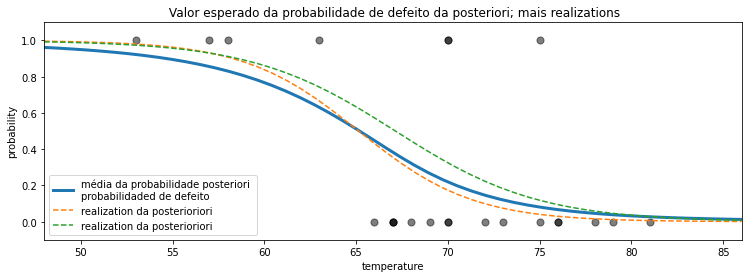

In [79]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="média da probabilidade posteriori \nprobabilidaded \
de defeito")
plt.plot(t, p_t[0, :], ls="--", label="realization da posterioriori")
plt.plot(t, p_t[-2, :], ls="--", label="realization da posterioriori")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title(" Valor esperado da probabilidade de defeito da posteriori; \
mais realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

No gráfico acima nós plotamos também os possíveis valores das realizations. A diferença entre uma variável aleatória X e sua realization é a diferença entre a distribuição e uma amostra da distribuição. A curva azul é o que ocorre quando calculamos a média de todas as 20.000 linhas pontilhadas possíveis juntas.

Uma pergunta que podemos fazer é para quais temperaturas estamoos temos mais incertezas sobre a probabilidade de defeito? Abaixo temos o plot do valor esperado e o 95% de intervalor associado a cada temperatura.

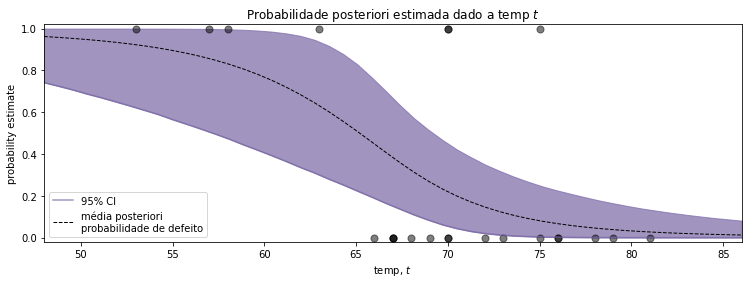

In [83]:

from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="média posteriori \nprobabilidade de defeito")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Probabilidade posteriori estimada dado a temp $t$");

A pintura roxa representa 95% de intervalo de credibilidade (CI). Esse é o intervalo, para cada temperatura, que contém 95% da distribuição. Por exemplo, quanto a temperatura é de 65 graus, nós podemos ter 95% de certeza que a probabilidade de defeito está entre 0.25 e 0.8.

De maneira geral, podemos notar que à medida que a temperatura se aproxima de 60 graus, os ICs se espalham rapidamente por [0,1]. À medida que passamos de 70 graus, os CIs tendem a se encurtar. Apesar da grande incerteza, isso nos dá uma visão de como proceder: provavelmente devemos testar mais aneis de conexão em torno de 60-65 graus de temperatura para obnter uma estimativa melhor das probabilidades nesse intervalor. Da mesma forma, ao relatar aos cientistas suas estimativa, você deve ser mais cauteloso ao simplesmente informar a probabilidade esperada, pois podemos ver que isso não reflete o quão *larga* é a distribuição posteriori.


---

###  Vamos analisar o dia em que o desastre ocorreu


No dia em que houve o desastre, a temperatura externa estava 31 graus Fahrenheit. A pergunta que queremos fazer é: qual é a distribuição posteriori de um defeito ocorrer nessa temperatura? Vamos plotar a distribuição abaixo.

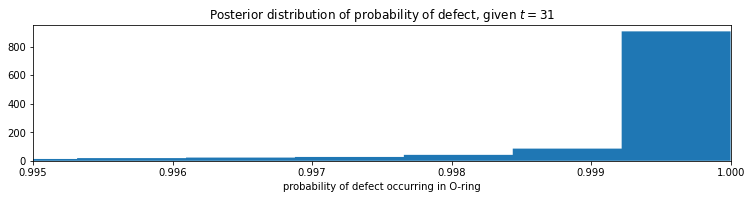

In [84]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, density=True, histtype='stepfilled')
plt.title("Distribuição posteriPosterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

Pelo plot podemos observar que temos uma grande probabilidade de ocorrer defeito nos aneis de conexão com essa temperatura.
